In [22]:
import pandas as pd
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn import metrics
from datetime import datetime
import numpy as np

In [2]:
df = pd.read_csv('./clean_data_after_eda.csv')
df["date_activ"] = pd.to_datetime(df["date_activ"], format='%Y-%m-%d')
df["date_end"] = pd.to_datetime(df["date_end"], format='%Y-%m-%d')
df["date_modif_prod"] = pd.to_datetime(df["date_modif_prod"], format='%Y-%m-%d')
df["date_renewal"] = pd.to_datetime(df["date_renewal"], format='%Y-%m-%d')

In [3]:
price_df = pd.read_csv('price_data.csv')
price_df["price_date"] = pd.to_datetime(price_df["price_date"], format='%Y-%m-%d')
price_df.head()

,id,price_date,price_off_peak_var,price_peak_var,price_mid_peak_var,price_off_peak_fix,price_peak_fix,price_mid_peak_fix
0,038af19179925da21a25619c5a24b745,2015-01-01,0.151367,0.0,0.0,44.266931,0.0,0.0
1,038af19179925da21a25619c5a24b745,2015-02-01,0.151367,0.0,0.0,44.266931,0.0,0.0
2,038af19179925da21a25619c5a24b745,2015-03-01,0.151367,0.0,0.0,44.266931,0.0,0.0
3,038af19179925da21a25619c5a24b745,2015-04-01,0.149626,0.0,0.0,44.266931,0.0,0.0
4,038af19179925da21a25619c5a24b745,2015-05-01,0.149626,0.0,0.0,44.266931,0.0,0.0


### Feature Engineering

In [4]:
#grouping by id and price date and aggregating the prices by mean
monthly_price_by_id = price_df.groupby(['id', 'price_date']).agg({'price_off_peak_var': 'mean', 'price_off_peak_fix': 'mean'}).reset_index()

In [5]:
monthly_price_by_id

,id,price_date,price_off_peak_var,price_off_peak_fix
0,0002203ffbb812588b632b9e628cc38d,2015-01-01,0.126098,40.565969
1,0002203ffbb812588b632b9e628cc38d,2015-02-01,0.126098,40.565969
2,0002203ffbb812588b632b9e628cc38d,2015-03-01,0.128067,40.728885
3,0002203ffbb812588b632b9e628cc38d,2015-04-01,0.128067,40.728885
4,0002203ffbb812588b632b9e628cc38d,2015-05-01,0.128067,40.728885
...,...,...,...,...
192997,ffff7fa066f1fb305ae285bb03bf325a,2015-08-01,0.119916,40.728885
192998,ffff7fa066f1fb305ae285bb03bf325a,2015-09-01,0.119916,40.728885
192999,ffff7fa066f1fb305ae285bb03bf325a,2015-10-01,0.119916,40.728885
193000,ffff7fa066f1fb305ae285bb03bf325a,2015-11-01,0.119916,40.728885


In [8]:
#getting the jan and dec prices
jan_prices = monthly_price_by_id.groupby('id').first().reset_index()
dec_prices = monthly_price_by_id.groupby('id').last().reset_index()

In [9]:
#finding the difference between jan and dec prices
diff = pd.merge(dec_prices.rename(columns={'price_off_peak_var': 'dec_1', 'price_off_peak_fix': 'dec_2'}), jan_prices.drop(columns='price_date'), on='id')
diff['offpeak_diff_dec_january_energy'] = diff['dec_1'] - diff['price_off_peak_var']
diff['offpeak_diff_dec_january_power'] = diff['dec_2'] - diff['price_off_peak_fix']
diff = diff[['id', 'offpeak_diff_dec_january_energy','offpeak_diff_dec_january_power']]
diff.head()

,id,offpeak_diff_dec_january_energy,offpeak_diff_dec_january_power
0,0002203ffbb812588b632b9e628cc38d,-0.006192,0.162916
1,0004351ebdd665e6ee664792efc4fd13,-0.004104,0.177779
2,0010bcc39e42b3c2131ed2ce55246e3c,0.050443,1.500000
3,0010ee3855fdea87602a5b7aba8e42de,-0.010018,0.162916
4,00114d74e963e47177db89bc70108537,-0.003994,-0.000001


In [10]:
df = pd.merge(df, diff, on='id')
df.head()

,Unnamed: 0,id,channel_sales,cons_12m,cons_gas_12m,cons_last_month,date_activ,date_end,date_modif_prod,date_renewal,...,mean_6m_price_p3,mean_3m_price_p1_var,mean_3m_price_p2_var,mean_3m_price_p3_var,mean_3m_price_p1_fix,mean_3m_price_p2_fix,mean_3m_price_p3_fix,churn,offpeak_diff_dec_january_energy,offpeak_diff_dec_january_power
0,0,24011ae4ebbe3035111d65fa7c15bc57,foosdfpfkusacimwkcsosbicdxkicaua,0,54946,0,2013-06-15,2016-06-15,2015-11-01,2015-06-23,...,13.637821,0.131756,0.092638,0.036909,42.497907,12.218665,8.145777,1,0.020057,3.700961
1,1,d29c2c54acc38ff3c0614d0a653813dd,MISSING,4660,0,0,2009-08-21,2016-08-30,2009-08-21,2015-08-31,...,0.000000,0.147600,0.000000,0.000000,44.444710,0.000000,0.000000,0,-0.003767,0.177779
2,2,764c75f661154dac3a6c254cd082ea7d,foosdfpfkusacimwkcsosbicdxkicaua,544,0,0,2010-04-16,2016-04-16,2010-04-16,2015-04-17,...,0.000000,0.167798,0.088409,0.000000,44.444710,0.000000,0.000000,0,-0.004670,0.177779
3,3,bba03439a292a1e166f80264c16191cb,lmkebamcaaclubfxadlmueccxoimlema,1584,0,0,2010-03-30,2016-03-30,2010-03-30,2015-03-31,...,0.000000,0.148586,0.000000,0.000000,44.444710,0.000000,0.000000,0,-0.004547,0.177779
4,4,149d57cf92fc41cf94415803a877cb4b,MISSING,4425,0,526,2010-01-13,2016-03-07,2010-01-13,2015-03-09,...,16.365283,0.119906,0.101673,0.073719,40.728885,24.437330,16.291555,0,-0.006192,0.162916


In [11]:
#finding mean of prices accross various periods
mean_prices = price_df.groupby(['id']).agg({
    'price_off_peak_var': 'mean', 
    'price_peak_var': 'mean', 
    'price_mid_peak_var': 'mean',
    'price_off_peak_fix': 'mean',
    'price_peak_fix': 'mean',
    'price_mid_peak_fix': 'mean'    
}).reset_index()

In [12]:
mean_prices

,id,price_off_peak_var,price_peak_var,price_mid_peak_var,price_off_peak_fix,price_peak_fix,price_mid_peak_fix
0,0002203ffbb812588b632b9e628cc38d,0.124338,0.103794,0.073160,40.701732,24.421038,16.280694
1,0004351ebdd665e6ee664792efc4fd13,0.146426,0.000000,0.000000,44.385450,0.000000,0.000000
2,0010bcc39e42b3c2131ed2ce55246e3c,0.181558,0.000000,0.000000,45.319710,0.000000,0.000000
3,0010ee3855fdea87602a5b7aba8e42de,0.118757,0.098292,0.069032,40.647427,24.388455,16.258971
4,00114d74e963e47177db89bc70108537,0.147926,0.000000,0.000000,44.266930,0.000000,0.000000
...,...,...,...,...,...,...,...
16091,ffef185810e44254c3a4c6395e6b4d8a,0.138863,0.115125,0.080780,40.896427,24.637456,16.507972
16092,fffac626da707b1b5ab11e8431a4d0a2,0.147137,0.000000,0.000000,44.311375,0.000000,0.000000
16093,fffc0cacd305dd51f316424bbb08d1bd,0.153879,0.129497,0.094842,41.160171,24.895768,16.763569
16094,fffe4f5646aa39c7f97f95ae2679ce64,0.123858,0.103499,0.073735,40.606699,24.364017,16.242678


In [13]:
#getting the price differenc eof various periods
mean_prices['off_peak_peak_var_mean_diff'] = mean_prices['price_off_peak_var'] - mean_prices['price_peak_var']
mean_prices['peak_mid_peak_var_mean_diff'] = mean_prices['price_peak_var'] - mean_prices['price_mid_peak_var']
mean_prices['off_peak_mid_peak_var_mean_diff'] = mean_prices['price_off_peak_var'] - mean_prices['price_mid_peak_var']
mean_prices['off_peak_peak_fix_mean_diff'] = mean_prices['price_off_peak_fix'] - mean_prices['price_peak_fix']
mean_prices['peak_mid_peak_fix_mean_diff'] = mean_prices['price_peak_fix'] - mean_prices['price_mid_peak_fix']
mean_prices['off_peak_mid_peak_fix_mean_diff'] = mean_prices['price_off_peak_fix'] - mean_prices['price_mid_peak_fix']

In [14]:
columns = [
    'id', 
    'off_peak_peak_var_mean_diff',
    'peak_mid_peak_var_mean_diff', 
    'off_peak_mid_peak_var_mean_diff',
    'off_peak_peak_fix_mean_diff', 
    'peak_mid_peak_fix_mean_diff', 
    'off_peak_mid_peak_fix_mean_diff'
]
df = pd.merge(df, mean_prices[columns], on='id')
df.head()

,Unnamed: 0,id,channel_sales,cons_12m,cons_gas_12m,cons_last_month,date_activ,date_end,date_modif_prod,date_renewal,...,mean_3m_price_p3_fix,churn,offpeak_diff_dec_january_energy,offpeak_diff_dec_january_power,off_peak_peak_var_mean_diff,peak_mid_peak_var_mean_diff,off_peak_mid_peak_var_mean_diff,off_peak_peak_fix_mean_diff,peak_mid_peak_fix_mean_diff,off_peak_mid_peak_fix_mean_diff
0,0,24011ae4ebbe3035111d65fa7c15bc57,foosdfpfkusacimwkcsosbicdxkicaua,0,54946,0,2013-06-15,2016-06-15,2015-11-01,2015-06-23,...,8.145777,1,0.020057,3.700961,0.024038,0.034219,0.058257,18.590255,7.450670,26.040925
1,1,d29c2c54acc38ff3c0614d0a653813dd,MISSING,4660,0,0,2009-08-21,2016-08-30,2009-08-21,2015-08-31,...,0.000000,0,-0.003767,0.177779,0.142485,0.007124,0.149609,44.311375,0.000000,44.311375
2,2,764c75f661154dac3a6c254cd082ea7d,foosdfpfkusacimwkcsosbicdxkicaua,544,0,0,2010-04-16,2016-04-16,2010-04-16,2015-04-17,...,0.000000,0,-0.004670,0.177779,0.082090,0.088421,0.170512,44.385450,0.000000,44.385450
3,3,bba03439a292a1e166f80264c16191cb,lmkebamcaaclubfxadlmueccxoimlema,1584,0,0,2010-03-30,2016-03-30,2010-03-30,2015-03-31,...,0.000000,0,-0.004547,0.177779,0.151210,0.000000,0.151210,44.400265,0.000000,44.400265
4,4,149d57cf92fc41cf94415803a877cb4b,MISSING,4425,0,526,2010-01-13,2016-03-07,2010-01-13,2015-03-09,...,16.291555,0,-0.006192,0.162916,0.020536,0.030773,0.051309,16.275263,8.137629,24.412893


In [15]:
#getting the mar price change across various periods and by month
mean_prices_by_month = price_df.groupby(['id', 'price_date']).agg({
    'price_off_peak_var': 'mean', 
    'price_peak_var': 'mean', 
    'price_mid_peak_var': 'mean',
    'price_off_peak_fix': 'mean',
    'price_peak_fix': 'mean',
    'price_mid_peak_fix': 'mean'    
}).reset_index()

In [16]:
mean_prices_by_month

,id,price_date,price_off_peak_var,price_peak_var,price_mid_peak_var,price_off_peak_fix,price_peak_fix,price_mid_peak_fix
0,0002203ffbb812588b632b9e628cc38d,2015-01-01,0.126098,0.103975,0.070232,40.565969,24.339581,16.226389
1,0002203ffbb812588b632b9e628cc38d,2015-02-01,0.126098,0.103975,0.070232,40.565969,24.339581,16.226389
2,0002203ffbb812588b632b9e628cc38d,2015-03-01,0.128067,0.105842,0.073773,40.728885,24.437330,16.291555
3,0002203ffbb812588b632b9e628cc38d,2015-04-01,0.128067,0.105842,0.073773,40.728885,24.437330,16.291555
4,0002203ffbb812588b632b9e628cc38d,2015-05-01,0.128067,0.105842,0.073773,40.728885,24.437330,16.291555
...,...,...,...,...,...,...,...,...
192997,ffff7fa066f1fb305ae285bb03bf325a,2015-08-01,0.119916,0.102232,0.076257,40.728885,24.437330,16.291555
192998,ffff7fa066f1fb305ae285bb03bf325a,2015-09-01,0.119916,0.102232,0.076257,40.728885,24.437330,16.291555
192999,ffff7fa066f1fb305ae285bb03bf325a,2015-10-01,0.119916,0.102232,0.076257,40.728885,24.437330,16.291555
193000,ffff7fa066f1fb305ae285bb03bf325a,2015-11-01,0.119916,0.102232,0.076257,40.728885,24.437330,16.291555


In [18]:
#getting the difference between the above periods
mean_prices_by_month['off_peak_peak_var_mean_diff'] = mean_prices_by_month['price_off_peak_var'] - mean_prices_by_month['price_peak_var']
mean_prices_by_month['peak_mid_peak_var_mean_diff'] = mean_prices_by_month['price_peak_var'] - mean_prices_by_month['price_mid_peak_var']
mean_prices_by_month['off_peak_mid_peak_var_mean_diff'] = mean_prices_by_month['price_off_peak_var'] - mean_prices_by_month['price_mid_peak_var']
mean_prices_by_month['off_peak_peak_fix_mean_diff'] = mean_prices_by_month['price_off_peak_fix'] - mean_prices_by_month['price_peak_fix']
mean_prices_by_month['peak_mid_peak_fix_mean_diff'] = mean_prices_by_month['price_peak_fix'] - mean_prices_by_month['price_mid_peak_fix']
mean_prices_by_month['off_peak_mid_peak_fix_mean_diff'] = mean_prices_by_month['price_off_peak_fix'] - mean_prices_by_month['price_mid_peak_fix']

In [19]:
# getting the max of the difference and renaming the columns
max_diff_across_periods_months = mean_prices_by_month.groupby(['id']).agg({
    'off_peak_peak_var_mean_diff': 'max',
    'peak_mid_peak_var_mean_diff': 'max',
    'off_peak_mid_peak_var_mean_diff': 'max',
    'off_peak_peak_fix_mean_diff': 'max',
    'peak_mid_peak_fix_mean_diff': 'max',
    'off_peak_mid_peak_fix_mean_diff': 'max'
}).reset_index().rename(
    columns={
        'off_peak_peak_var_mean_diff': 'off_peak_peak_var_max_monthly_diff',
        'peak_mid_peak_var_mean_diff': 'peak_mid_peak_var_max_monthly_diff',
        'off_peak_mid_peak_var_mean_diff': 'off_peak_mid_peak_var_max_monthly_diff',
        'off_peak_peak_fix_mean_diff': 'off_peak_peak_fix_max_monthly_diff',
        'peak_mid_peak_fix_mean_diff': 'peak_mid_peak_fix_max_monthly_diff',
        'off_peak_mid_peak_fix_mean_diff': 'off_peak_mid_peak_fix_max_monthly_diff'
    }
)

In [20]:
columns = [
    'id',
    'off_peak_peak_var_max_monthly_diff',
    'peak_mid_peak_var_max_monthly_diff',
    'off_peak_mid_peak_var_max_monthly_diff',
    'off_peak_peak_fix_max_monthly_diff',
    'peak_mid_peak_fix_max_monthly_diff',
    'off_peak_mid_peak_fix_max_monthly_diff'
]

df = pd.merge(df, max_diff_across_periods_months[columns], on='id')
df.head()

,Unnamed: 0,id,channel_sales,cons_12m,cons_gas_12m,cons_last_month,date_activ,date_end,date_modif_prod,date_renewal,...,off_peak_mid_peak_var_mean_diff,off_peak_peak_fix_mean_diff,peak_mid_peak_fix_mean_diff,off_peak_mid_peak_fix_mean_diff,off_peak_peak_var_max_monthly_diff,peak_mid_peak_var_max_monthly_diff,off_peak_mid_peak_var_max_monthly_diff,off_peak_peak_fix_max_monthly_diff,peak_mid_peak_fix_max_monthly_diff,off_peak_mid_peak_fix_max_monthly_diff
0,0,24011ae4ebbe3035111d65fa7c15bc57,foosdfpfkusacimwkcsosbicdxkicaua,0,54946,0,2013-06-15,2016-06-15,2015-11-01,2015-06-23,...,0.058257,18.590255,7.450670,26.040925,0.060550,0.085483,0.146033,44.266930,8.145775,44.26693
1,1,d29c2c54acc38ff3c0614d0a653813dd,MISSING,4660,0,0,2009-08-21,2016-08-30,2009-08-21,2015-08-31,...,0.149609,44.311375,0.000000,44.311375,0.151367,0.085483,0.151367,44.444710,0.000000,44.44471
2,2,764c75f661154dac3a6c254cd082ea7d,foosdfpfkusacimwkcsosbicdxkicaua,544,0,0,2010-04-16,2016-04-16,2010-04-16,2015-04-17,...,0.170512,44.385450,0.000000,44.385450,0.084587,0.089162,0.172468,44.444710,0.000000,44.44471
3,3,bba03439a292a1e166f80264c16191cb,lmkebamcaaclubfxadlmueccxoimlema,1584,0,0,2010-03-30,2016-03-30,2010-03-30,2015-03-31,...,0.151210,44.400265,0.000000,44.400265,0.153133,0.000000,0.153133,44.444710,0.000000,44.44471
4,4,149d57cf92fc41cf94415803a877cb4b,MISSING,4425,0,526,2010-01-13,2016-03-07,2010-01-13,2015-03-09,...,0.051309,16.275263,8.137629,24.412893,0.022225,0.033743,0.055866,16.291555,8.145775,24.43733


In [23]:
# creating loyality as a feature
df['tenure'] = ((df['date_end'] - df['date_activ'])/ np.timedelta64(1, 'Y')).astype(int)

In [24]:
df.groupby(['tenure']).agg({'churn': 'mean'}).sort_values(by='churn', ascending=False)

,churn
tenure,
3,0.143836
2,0.133080
4,0.125756
13,0.095238
5,0.085425
12,0.083333
6,0.080713
7,0.073394
11,0.063584


Here we can notice that churn is high when tenure is less than 4 years. As the tenure increases, customers are not changing PowerCo's service.

In [25]:
def convert_months(reference_date, df, column):

    time_delta = reference_date - df[column]
    months = (time_delta / np.timedelta64(1, 'M')).astype(int)
    return months
#reference date is the date from which we want to calculate the number of months

In [26]:
reference_date = datetime(2016, 1, 1)

# creating a new column with the number of months
df['months_activ'] = convert_months(reference_date, df, 'date_activ')
df['months_to_end'] = -convert_months(reference_date, df, 'date_end')
df['months_modif_prod'] = convert_months(reference_date, df, 'date_modif_prod')
df['months_renewal'] = convert_months(reference_date, df, 'date_renewal')

In [27]:
#dropping all other dates as they're of no use
remove = [
    'date_activ',
    'date_end',
    'date_modif_prod',
    'date_renewal'
]

df = df.drop(columns=remove)
df.head()

,Unnamed: 0,id,channel_sales,cons_12m,cons_gas_12m,cons_last_month,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,forecast_meter_rent_12m,...,peak_mid_peak_var_max_monthly_diff,off_peak_mid_peak_var_max_monthly_diff,off_peak_peak_fix_max_monthly_diff,peak_mid_peak_fix_max_monthly_diff,off_peak_mid_peak_fix_max_monthly_diff,tenure,months_activ,months_to_end,months_modif_prod,months_renewal
0,0,24011ae4ebbe3035111d65fa7c15bc57,foosdfpfkusacimwkcsosbicdxkicaua,0,54946,0,0.00,0,0.0,1.78,...,0.085483,0.146033,44.266930,8.145775,44.26693,3,30,5,2,6
1,1,d29c2c54acc38ff3c0614d0a653813dd,MISSING,4660,0,0,189.95,0,0.0,16.27,...,0.085483,0.151367,44.444710,0.000000,44.44471,7,76,7,76,4
2,2,764c75f661154dac3a6c254cd082ea7d,foosdfpfkusacimwkcsosbicdxkicaua,544,0,0,47.96,0,0.0,38.72,...,0.089162,0.172468,44.444710,0.000000,44.44471,6,68,3,68,8
3,3,bba03439a292a1e166f80264c16191cb,lmkebamcaaclubfxadlmueccxoimlema,1584,0,0,240.04,0,0.0,19.83,...,0.000000,0.153133,44.444710,0.000000,44.44471,6,69,2,69,9
4,4,149d57cf92fc41cf94415803a877cb4b,MISSING,4425,0,526,445.75,526,0.0,131.73,...,0.033743,0.055866,16.291555,8.145775,24.43733,6,71,2,71,9


In [29]:
#converting channel sales into categories as there are only 8 types
df['channel_sales'] = df['channel_sales'].astype('category')

In [30]:
df['channel_sales'].value_counts()

foosdfpfkusacimwkcsosbicdxkicaua    6753
MISSING                             3725
lmkebamcaaclubfxadlmueccxoimlema    1843
usilxuppasemubllopkaafesmlibmsdf    1375
ewpakwlliwisiwduibdlfmalxowmwpci     893
sddiedcslfslkckwlfkdpoeeailfpeds      11
epumfxlbckeskwekxbiuasklxalciiuu       3
fixdbufsefwooaasfcxdxadsiekoceaa       2
Name: channel_sales, dtype: int64

In [31]:
# Dropping the last 3 channel sales as they are considerably very low when compared to others hence won't have much say during predicting
df = pd.get_dummies(df, columns=['channel_sales'], prefix='channel')

In [33]:
df = df.drop(columns=['channel_sddiedcslfslkckwlfkdpoeeailfpeds', 'channel_epumfxlbckeskwekxbiuasklxalciiuu', 'channel_fixdbufsefwooaasfcxdxadsiekoceaa'])
df.head()

,Unnamed: 0,id,cons_12m,cons_gas_12m,cons_last_month,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_off_peak,...,tenure,months_activ,months_to_end,months_modif_prod,months_renewal,channel_MISSING,channel_ewpakwlliwisiwduibdlfmalxowmwpci,channel_foosdfpfkusacimwkcsosbicdxkicaua,channel_lmkebamcaaclubfxadlmueccxoimlema,channel_usilxuppasemubllopkaafesmlibmsdf
0,0,24011ae4ebbe3035111d65fa7c15bc57,0,54946,0,0.00,0,0.0,1.78,0.114481,...,3,30,5,2,6,0,0,1,0,0
1,1,d29c2c54acc38ff3c0614d0a653813dd,4660,0,0,189.95,0,0.0,16.27,0.145711,...,7,76,7,76,4,1,0,0,0,0
2,2,764c75f661154dac3a6c254cd082ea7d,544,0,0,47.96,0,0.0,38.72,0.165794,...,6,68,3,68,8,0,0,1,0,0
3,3,bba03439a292a1e166f80264c16191cb,1584,0,0,240.04,0,0.0,19.83,0.146694,...,6,69,2,69,9,0,0,0,1,0
4,4,149d57cf92fc41cf94415803a877cb4b,4425,0,526,445.75,526,0.0,131.73,0.116900,...,6,71,2,71,9,1,0,0,0,0


In [34]:
df = pd.get_dummies(df, columns=['origin_up'], prefix='origin_up')
df = df.drop(columns=['origin_up_MISSING', 'origin_up_usapbepcfoloekilkwsdiboslwaxobdp', 'origin_up_ewxeelcelemmiwuafmddpobolfuxioce'])
df.head()

,Unnamed: 0,id,cons_12m,cons_gas_12m,cons_last_month,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_off_peak,...,months_modif_prod,months_renewal,channel_MISSING,channel_ewpakwlliwisiwduibdlfmalxowmwpci,channel_foosdfpfkusacimwkcsosbicdxkicaua,channel_lmkebamcaaclubfxadlmueccxoimlema,channel_usilxuppasemubllopkaafesmlibmsdf,origin_up_kamkkxfxxuwbdslkwifmmcsiusiuosws,origin_up_ldkssxwpmemidmecebumciepifcamkci,origin_up_lxidpiddsbxsbosboudacockeimpuepw
0,0,24011ae4ebbe3035111d65fa7c15bc57,0,54946,0,0.00,0,0.0,1.78,0.114481,...,2,6,0,0,1,0,0,0,0,1
1,1,d29c2c54acc38ff3c0614d0a653813dd,4660,0,0,189.95,0,0.0,16.27,0.145711,...,76,4,1,0,0,0,0,1,0,0
2,2,764c75f661154dac3a6c254cd082ea7d,544,0,0,47.96,0,0.0,38.72,0.165794,...,68,8,0,0,1,0,0,1,0,0
3,3,bba03439a292a1e166f80264c16191cb,1584,0,0,240.04,0,0.0,19.83,0.146694,...,69,9,0,0,0,1,0,1,0,0
4,4,149d57cf92fc41cf94415803a877cb4b,4425,0,526,445.75,526,0.0,131.73,0.116900,...,71,9,1,0,0,0,0,1,0,0


### Data Transformation

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2657: RuntimeWarning: Mean of empty slice.
  line, = ax.plot(a.mean(), 0)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


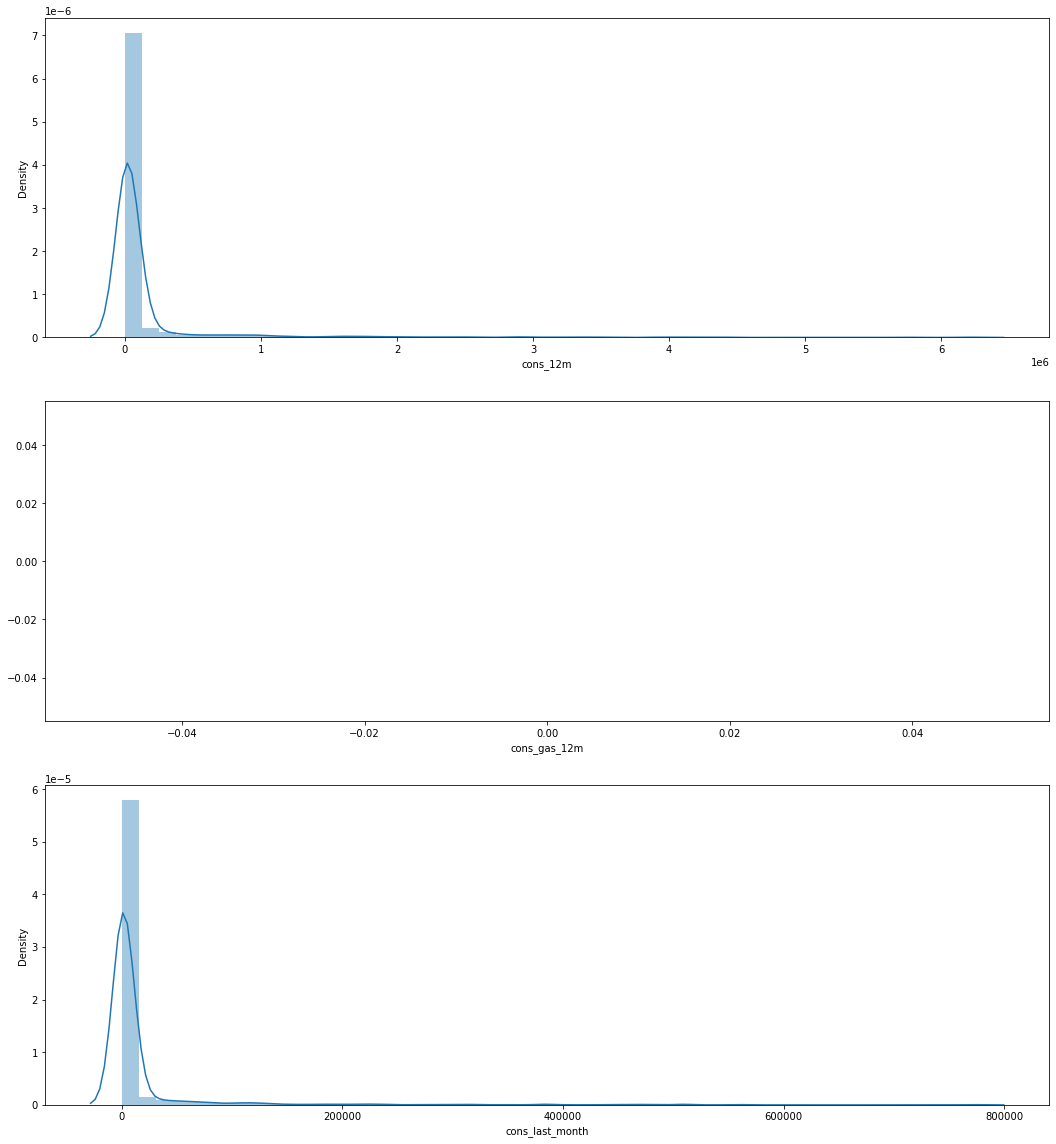

In [36]:
#we can see that the data is not normally distributed hence transformation is needed
fig, axs = plt.subplots(nrows=3, figsize=(18, 20))

sn.distplot((df["cons_12m"].dropna()), ax=axs[0])
sn.distplot((df[df["has_gas"]==1]["cons_gas_12m"].dropna()), ax=axs[1])
sn.distplot((df["cons_last_month"].dropna()), ax=axs[2])
plt.show()

In [37]:
skewed = [
    'cons_12m', 
    'cons_gas_12m', 
    'cons_last_month',
    'forecast_cons_12m', 
    'forecast_cons_year', 
    'forecast_discount_energy',
    'forecast_meter_rent_12m', 
    'forecast_price_energy_off_peak',
    'forecast_price_energy_peak', 
    'forecast_price_pow_off_peak'
]

df[skewed].describe()

,cons_12m,cons_gas_12m,cons_last_month,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_off_peak,forecast_price_energy_peak,forecast_price_pow_off_peak
count,1.460500e+04,1.460500e+04,14605.000000,14605.000000,14605.000000,14605.000000,14605.000000,14605.000000,14605.000000,14605.000000
mean,1.592303e+05,2.809108e+04,16091.371448,1868.638618,1399.858747,0.966450,63.090448,0.137282,0.050488,43.130085
std,5.734836e+05,1.629786e+05,64366.262314,2387.651549,3247.876793,5.108355,66.166636,0.024623,0.049037,4.486140
min,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,5.674000e+03,0.000000e+00,0.000000,494.980000,0.000000,0.000000,16.180000,0.116340,0.000000,40.606701
50%,1.411600e+04,0.000000e+00,793.000000,1112.610000,314.000000,0.000000,18.800000,0.143166,0.084138,44.311378
75%,4.076400e+04,0.000000e+00,3383.000000,2402.270000,1746.000000,0.000000,131.030000,0.146348,0.098837,44.311378
max,6.207104e+06,4.154590e+06,771203.000000,82902.830000,175375.000000,30.000000,599.310000,0.273963,0.195975,59.266378


In [38]:
df["cons_12m"] = np.log10(df["cons_12m"] + 1)
df["cons_gas_12m"] = np.log10(df["cons_gas_12m"] + 1)
df["cons_last_month"] = np.log10(df["cons_last_month"] + 1)
df["forecast_cons_12m"] = np.log10(df["forecast_cons_12m"] + 1)
df["forecast_cons_year"] = np.log10(df["forecast_cons_year"] + 1)
df["forecast_meter_rent_12m"] = np.log10(df["forecast_meter_rent_12m"] + 1)
df["imp_cons"] = np.log10(df["imp_cons"] + 1)

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2657: RuntimeWarning: Mean of empty slice.
  line, = ax.plot(a.mean(), 0)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


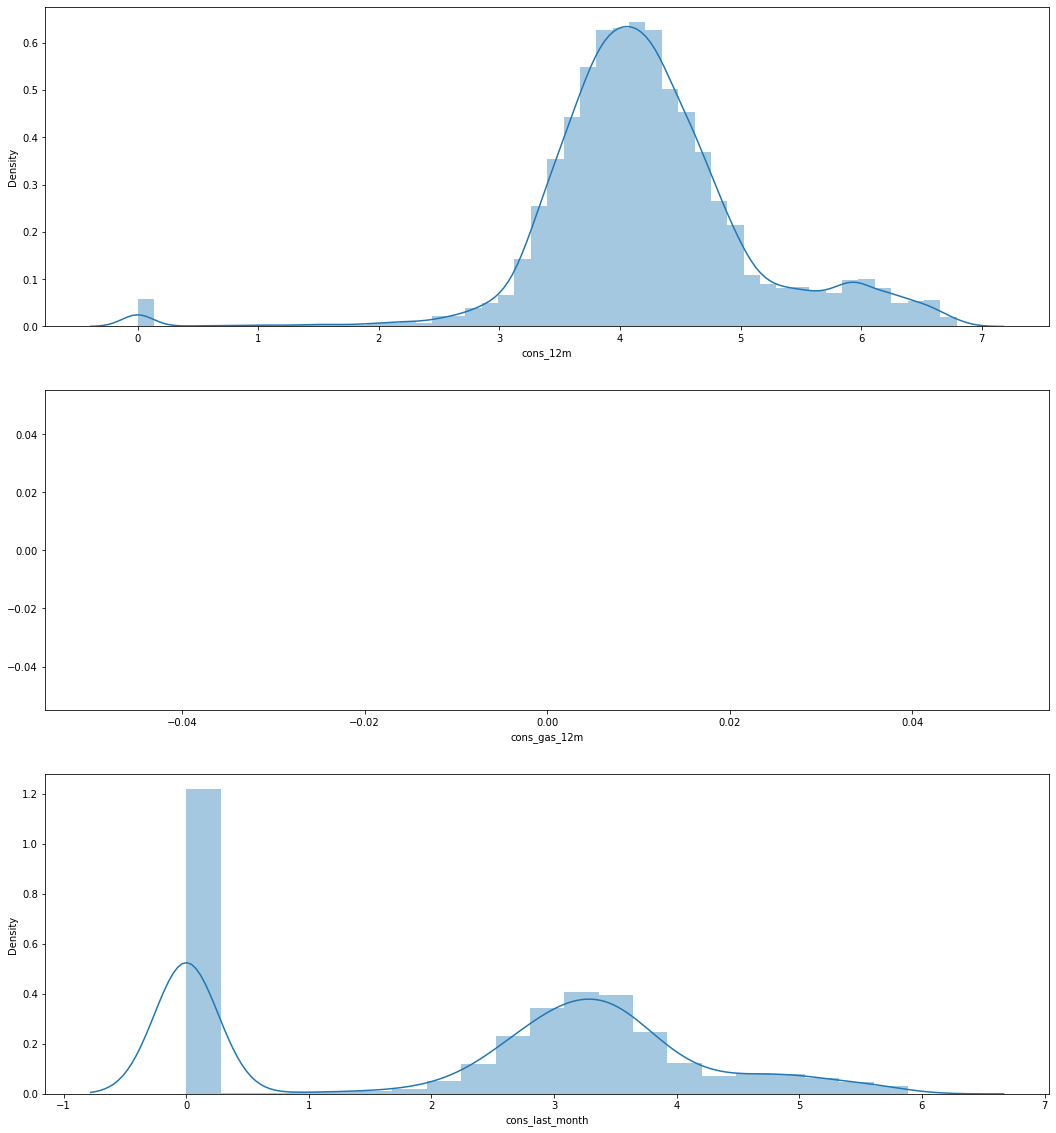

In [45]:
fig, axs = plt.subplots(nrows=3, figsize=(18, 20))
sn.distplot((df["cons_12m"].dropna()), ax=axs[0])
sn.distplot((df[df["has_gas"]==1]["cons_gas_12m"].dropna()), ax=axs[1])
sn.distplot((df["cons_last_month"].dropna()), ax=axs[2])
plt.show()

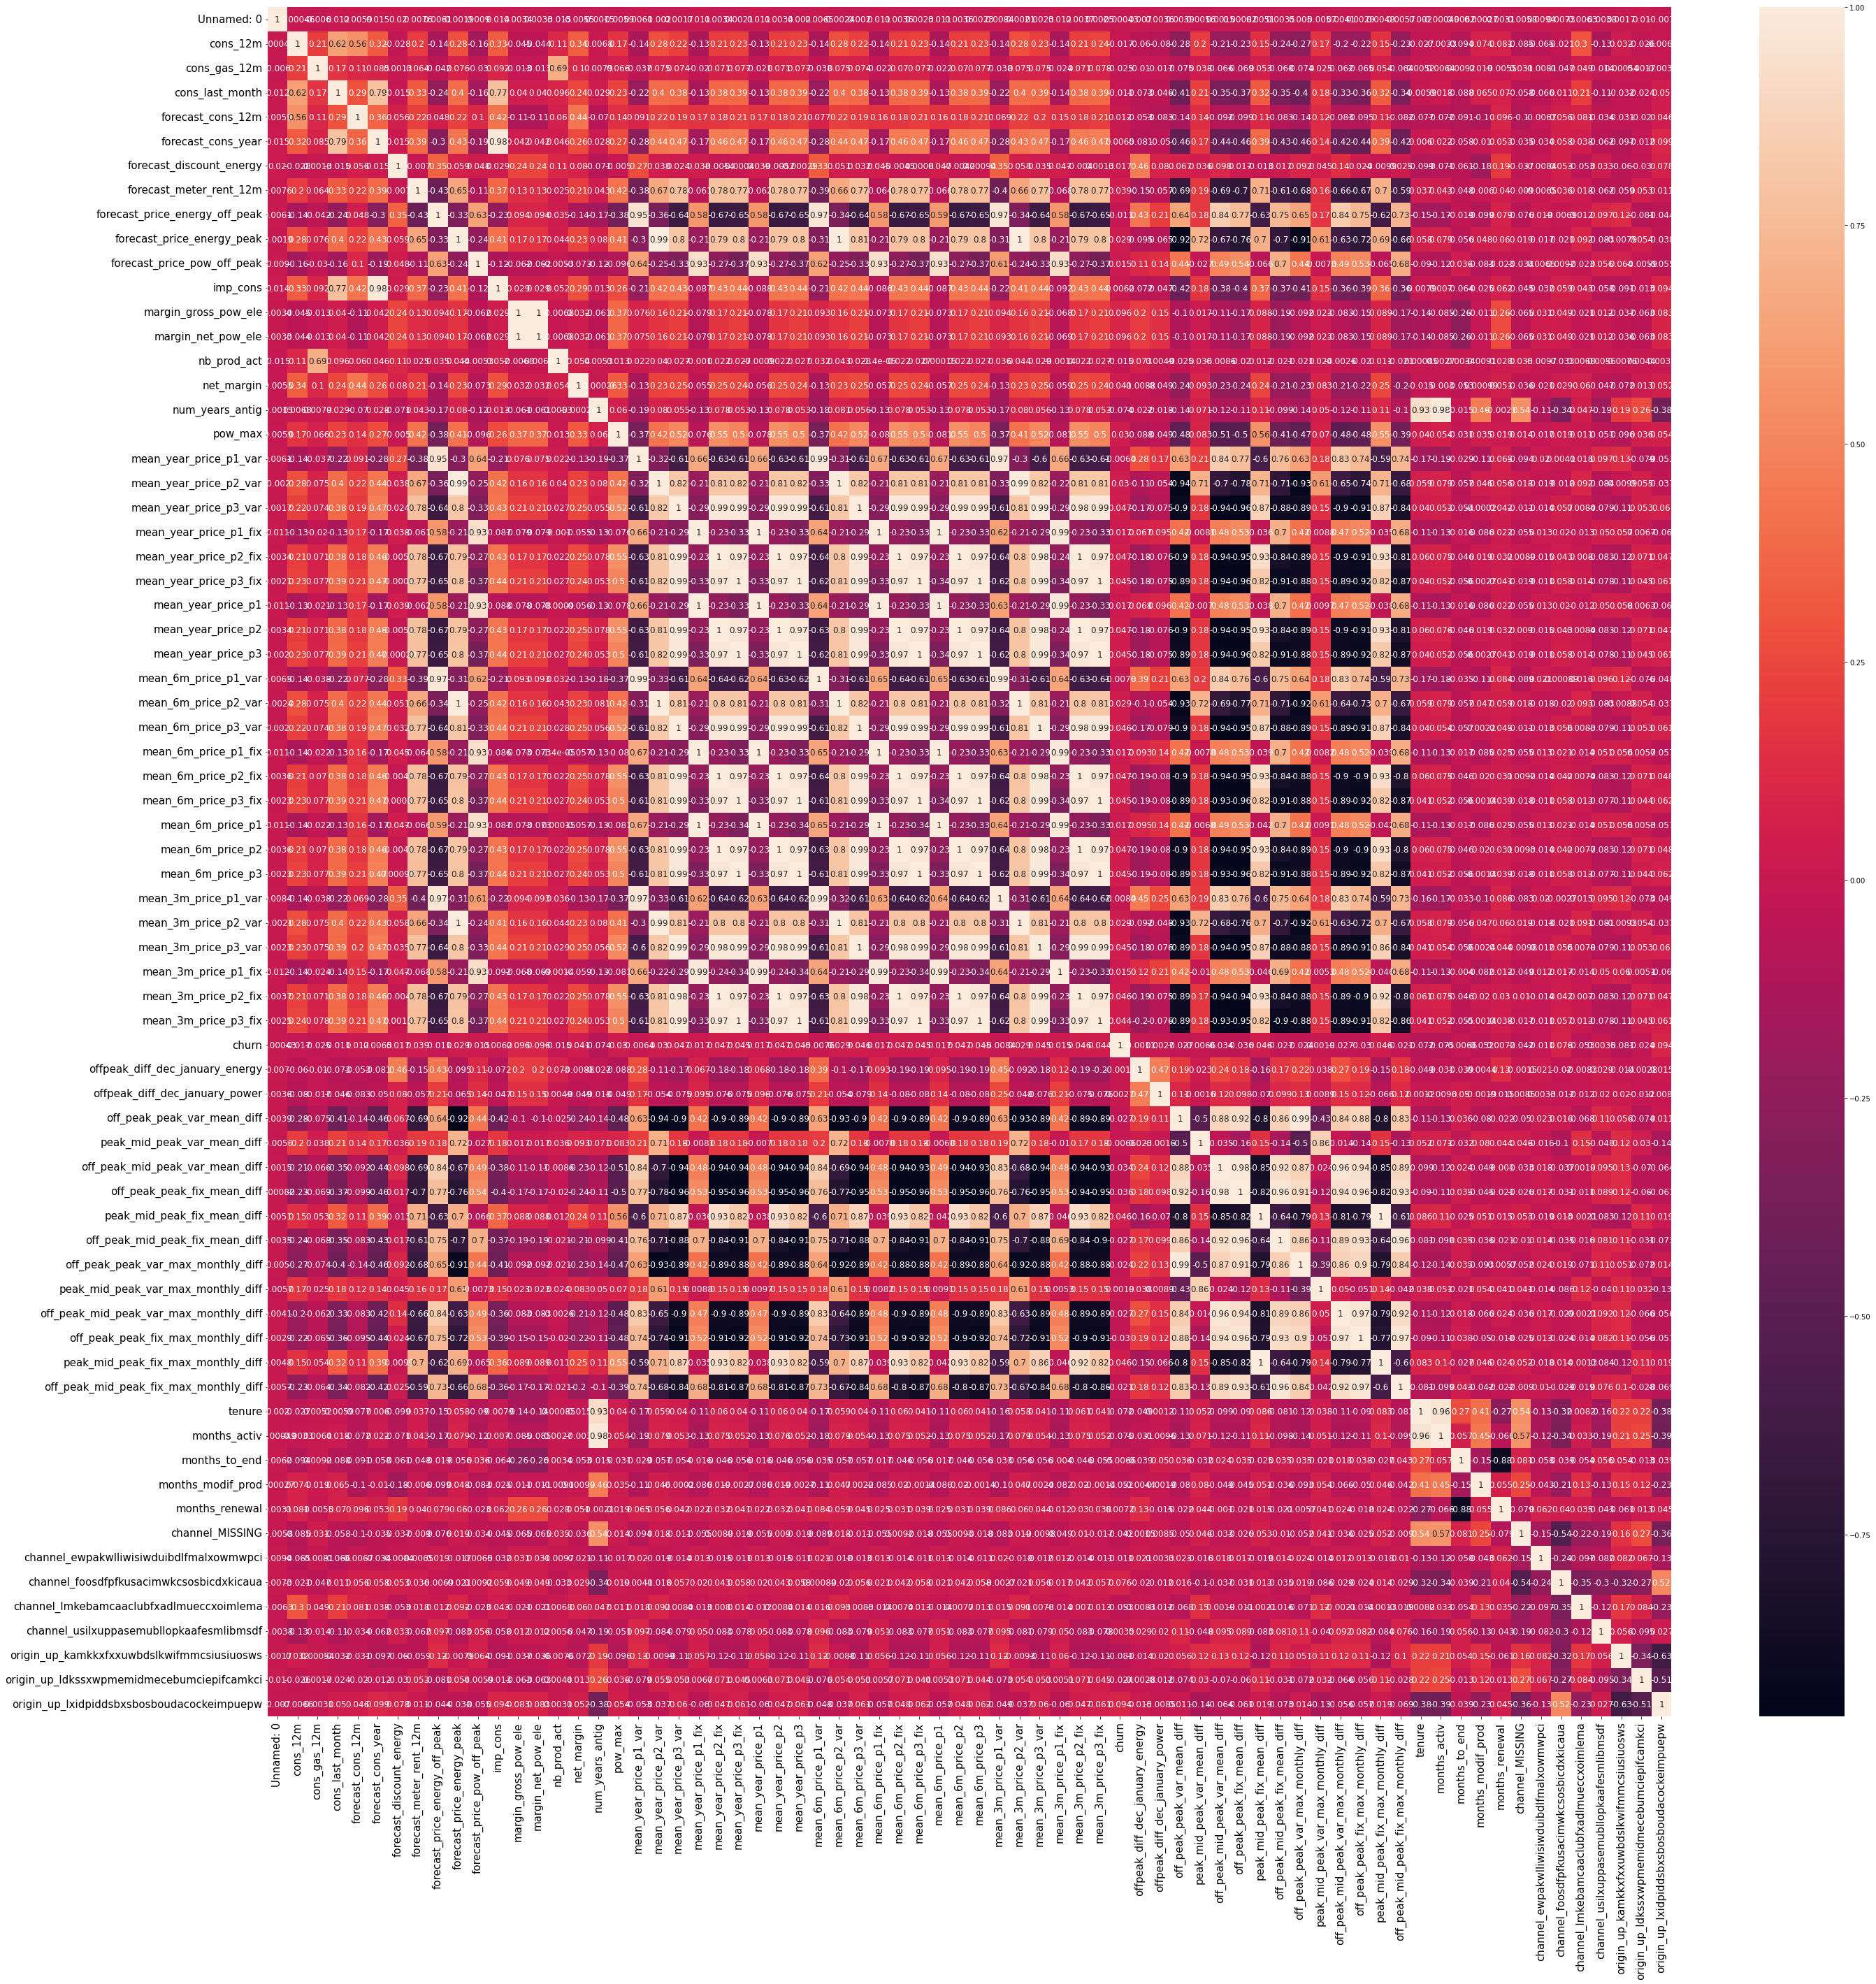

In [51]:
correlation = df.corr()
plt.figure(figsize=(45, 45))
sn.heatmap(
    correlation, 
    xticklabels=correlation.columns.values,
    yticklabels=correlation.columns.values, 
    annot=True, 
    annot_kws={'size': 12}
)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

In [52]:
#dropping antiquity years and forecasted consumption per year as they have high correlation with other features hence won't effect the model much
df = df.drop(columns=['num_years_antig', 'forecast_cons_year'])
df.head()

,Unnamed: 0,id,cons_12m,cons_gas_12m,cons_last_month,forecast_cons_12m,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_off_peak,forecast_price_energy_peak,...,months_modif_prod,months_renewal,channel_MISSING,channel_ewpakwlliwisiwduibdlfmalxowmwpci,channel_foosdfpfkusacimwkcsosbicdxkicaua,channel_lmkebamcaaclubfxadlmueccxoimlema,channel_usilxuppasemubllopkaafesmlibmsdf,origin_up_kamkkxfxxuwbdslkwifmmcsiusiuosws,origin_up_ldkssxwpmemidmecebumciepifcamkci,origin_up_lxidpiddsbxsbosboudacockeimpuepw
0,0,24011ae4ebbe3035111d65fa7c15bc57,0.000000,4.739944,0.000000,0.000000,0.0,0.444045,0.114481,0.098142,...,2,6,0,0,1,0,0,0,0,1
1,1,d29c2c54acc38ff3c0614d0a653813dd,3.668479,0.000000,0.000000,2.280920,0.0,1.237292,0.145711,0.000000,...,76,4,1,0,0,0,0,1,0,0
2,2,764c75f661154dac3a6c254cd082ea7d,2.736397,0.000000,0.000000,1.689841,0.0,1.599009,0.165794,0.087899,...,68,8,0,0,1,0,0,1,0,0
3,3,bba03439a292a1e166f80264c16191cb,3.200029,0.000000,0.000000,2.382089,0.0,1.318689,0.146694,0.000000,...,69,9,0,0,0,1,0,1,0,0
4,4,149d57cf92fc41cf94415803a877cb4b,3.646011,0.000000,2.721811,2.650065,0.0,2.122969,0.116900,0.100015,...,71,9,1,0,0,0,0,1,0,0


### ML Model 

In [64]:
train_df = df.copy()
y = df['churn']
X = df.drop(columns=['id', 'churn'])
print(X.shape)
print(y.shape)

(14605, 68)
(14605,)


In [77]:
y.value_counts()

0    13186
1     1419
Name: churn, dtype: int64

In [74]:
def t_f(x):
    if x == 't':
        return 0
    else:
        return 1

In [75]:
X['has_gas'] = X['has_gas'].apply(t_f)

In [76]:
X.head(3)

,Unnamed: 0,cons_12m,cons_gas_12m,cons_last_month,forecast_cons_12m,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_off_peak,forecast_price_energy_peak,forecast_price_pow_off_peak,has_gas,imp_cons,margin_gross_pow_ele,margin_net_pow_ele,nb_prod_act,net_margin,pow_max,mean_year_price_p1_var,mean_year_price_p2_var,mean_year_price_p3_var,mean_year_price_p1_fix,mean_year_price_p2_fix,mean_year_price_p3_fix,mean_year_price_p1,mean_year_price_p2,mean_year_price_p3,mean_6m_price_p1_var,mean_6m_price_p2_var,mean_6m_price_p3_var,mean_6m_price_p1_fix,mean_6m_price_p2_fix,mean_6m_price_p3_fix,mean_6m_price_p1,mean_6m_price_p2,mean_6m_price_p3,mean_3m_price_p1_var,mean_3m_price_p2_var,mean_3m_price_p3_var,mean_3m_price_p1_fix,mean_3m_price_p2_fix,mean_3m_price_p3_fix,offpeak_diff_dec_january_energy,offpeak_diff_dec_january_power,off_peak_peak_var_mean_diff,peak_mid_peak_var_mean_diff,off_peak_mid_peak_var_mean_diff,off_peak_peak_fix_mean_diff,peak_mid_peak_fix_mean_diff,off_peak_mid_peak_fix_mean_diff,off_peak_peak_var_max_monthly_diff,peak_mid_peak_var_max_monthly_diff,off_peak_mid_peak_var_max_monthly_diff,off_peak_peak_fix_max_monthly_diff,peak_mid_peak_fix_max_monthly_diff,off_peak_mid_peak_fix_max_monthly_diff,tenure,months_activ,months_to_end,months_modif_prod,months_renewal,channel_MISSING,channel_ewpakwlliwisiwduibdlfmalxowmwpci,channel_foosdfpfkusacimwkcsosbicdxkicaua,channel_lmkebamcaaclubfxadlmueccxoimlema,channel_usilxuppasemubllopkaafesmlibmsdf,origin_up_kamkkxfxxuwbdslkwifmmcsiusiuosws,origin_up_ldkssxwpmemidmecebumciepifcamkci,origin_up_lxidpiddsbxsbosboudacockeimpuepw
0,0,0.000000,4.739944,0.0,0.000000,0.0,0.444045,0.114481,0.098142,40.606701,0,0.0,25.44,25.44,2,678.99,43.648,0.124787,0.100749,0.06653,40.942265,22.35201,14.90134,41.067053,22.452760,14.967871,0.123598,0.098104,0.061525,41.318559,20.364442,13.576296,41.442157,20.462545,13.637821,0.131756,0.092638,0.036909,42.497907,12.218665,8.145777,0.020057,3.700961,0.024038,0.034219,0.058257,18.590255,7.45067,26.040925,0.060550,0.085483,0.146033,44.26693,8.145775,44.26693,3,30,5,2,6,0,0,1,0,0,0,0,1
1,1,3.668479,0.000000,0.0,2.280920,0.0,1.237292,0.145711,0.000000,44.311378,1,0.0,16.38,16.38,1,18.89,13.800,0.149609,0.007124,0.00000,44.311375,0.00000,0.00000,44.460984,0.007124,0.000000,0.147851,0.014247,0.000000,44.355820,0.000000,0.000000,44.503671,0.014247,0.000000,0.147600,0.000000,0.000000,44.444710,0.000000,0.000000,-0.003767,0.177779,0.142485,0.007124,0.149609,44.311375,0.00000,44.311375,0.151367,0.085483,0.151367,44.44471,0.000000,44.44471,7,76,7,76,4,1,0,0,0,0,1,0,0
2,2,2.736397,0.000000,0.0,1.689841,0.0,1.599009,0.165794,0.087899,44.311378,1,0.0,28.60,28.60,1,6.60,13.856,0.170512,0.088421,0.00000,44.385450,0.00000,0.00000,44.555962,0.088421,0.000000,0.168569,0.088535,0.000000,44.444710,0.000000,0.000000,44.613279,0.088535,0.000000,0.167798,0.088409,0.000000,44.444710,0.000000,0.000000,-0.004670,0.177779,0.082090,0.088421,0.170512,44.385450,0.00000,44.385450,0.084587,0.089162,0.172468,44.44471,0.000000,44.44471,6,68,3,68,8,0,0,1,0,0,1,0,0


In [78]:
smote = SMOTE(sampling_strategy='minority')
X_sm, y_sm = smote.fit_resample(X, y)

In [80]:
y_sm.value_counts()

1    13186
0    13186
Name: churn, dtype: int64

In [81]:
X_train, X_test, y_train, y_test = train_test_split(X_sm, y_sm, test_size=0.25, random_state=42)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(19779, 68)
(19779,)
(6593, 68)
(6593,)


In [82]:
model_params = {
    'Random Forest': {
        'model': RandomForestClassifier(),
        'params' : {
            'n_estimators': [20,50,100],
            'criterion': ['gini','entropy']
        }  
    }
    
}

In [83]:
scores = []

for model_name, mp in model_params.items():
    clf =  GridSearchCV(mp['model'], mp['params'], cv=5, return_train_score=False)
    clf.fit(X_sm, y_sm)
    scores.append({
        'model': model_name,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })
    
results = pd.DataFrame(scores,columns=['model','best_score','best_params'])
results

,model,best_score,best_params
0,Random Forest,0.791677,"{'criterion': 'entropy', 'n_estimators': 50}"


In [84]:
model = RandomForestClassifier(n_estimators=50)
model.fit(X_sm, y_sm)

RandomForestClassifier(n_estimators=50)

In [85]:
model.score(X_sm, y_sm)

0.9998483239799788

In [86]:
predictions = model.predict(X_test)
tn, fp, fn, tp = metrics.confusion_matrix(y_test, predictions).ravel()

In [87]:
print(f"True positives: {tp}")
print(f"False positives: {fp}")
print(f"True negatives: {tn}")
print(f"False negatives: {fn}\n")

print(f"Accuracy: {metrics.accuracy_score(y_test, predictions)}")
print(f"Precision: {metrics.precision_score(y_test, predictions)}")
print(f"Recall: {metrics.recall_score(y_test, predictions)}")

True positives: 3308
False positives: 0
True negatives: 3283
False negatives: 2

Accuracy: 0.9996966479599575
Precision: 1.0
Recall: 0.9993957703927493


### Feature Importance

In [88]:
feature_importances = pd.DataFrame({
    'features': X_train.columns,
    'importance': model.feature_importances_
}).sort_values(by='importance', ascending=True).reset_index()


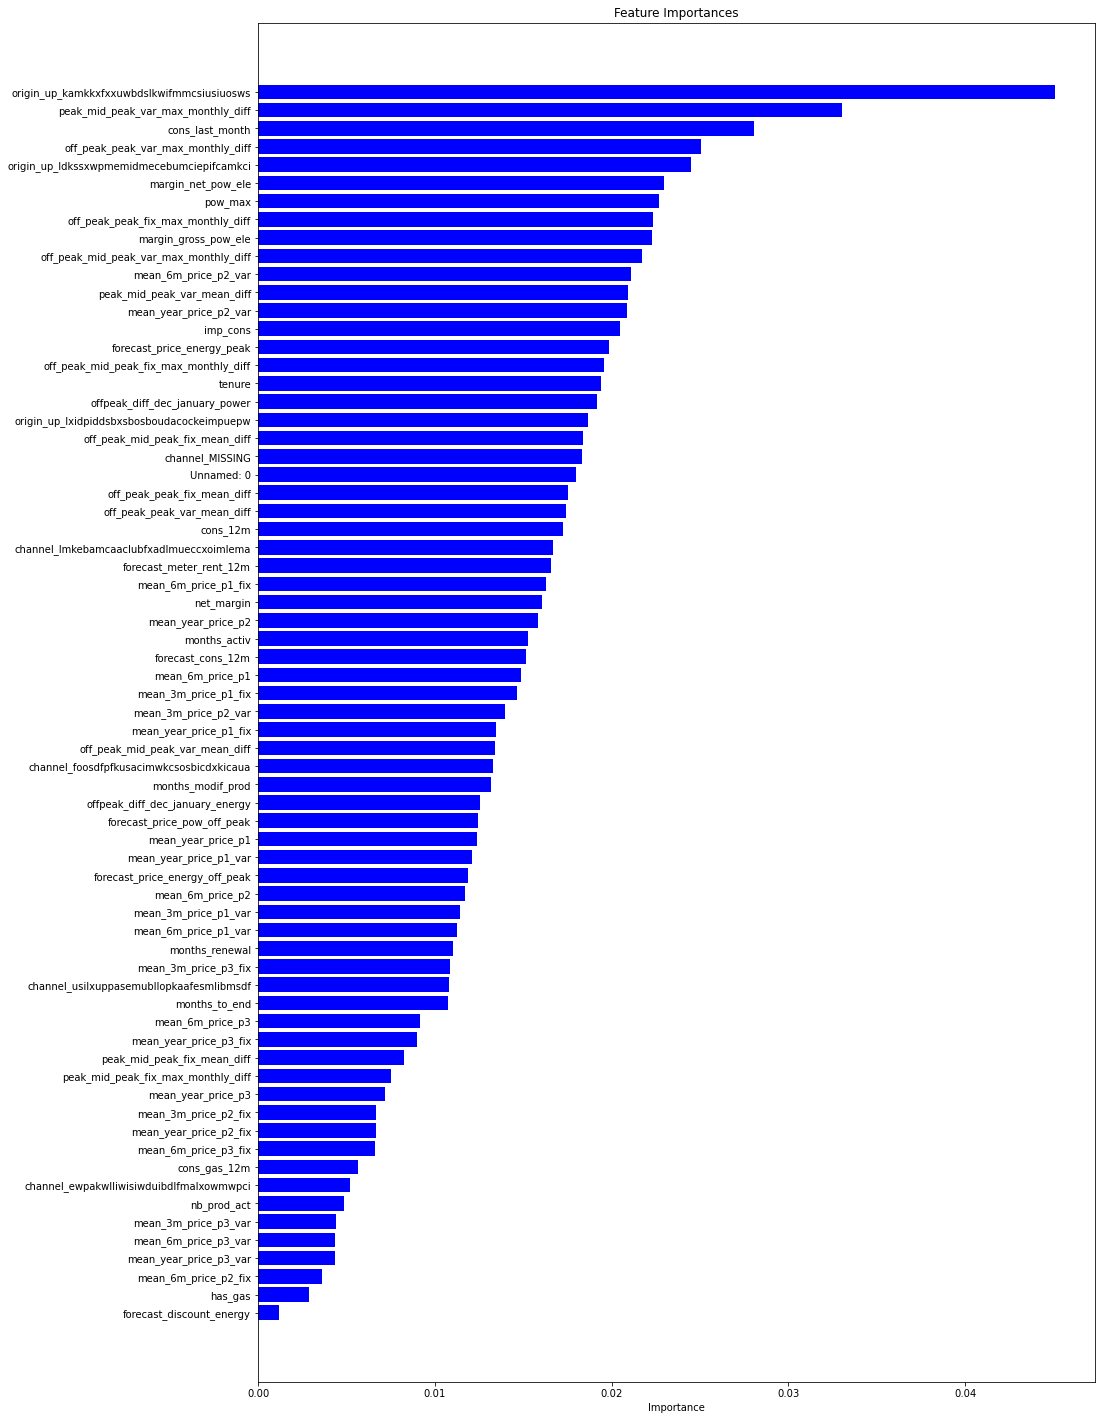

In [89]:
plt.figure(figsize=(15, 25))
plt.title('Feature Importances')
plt.barh(range(len(feature_importances)), feature_importances['importance'], color='b', align='center')
plt.yticks(range(len(feature_importances)), feature_importances['features'])
plt.xlabel('Importance')
plt.show()

As we can see the model was trained perfectly and gave us an accuracy of 99%. Two features were of most importance as seen above but to prove the orignal hypothesis that price sensitivity plays an important role we need more data (competitor price, customer econimic background) as the features were not conclusive. 

Advantages of Random Forest:
1.	Reduces over fitting by using ensemble techniques.
2.	Handles missing data automatically.
3.	Can be used for both regression and classification.


Disadvantages:
1.	Very complex computation.
2.	Small deviation in data may change the algorithm.
